# Phase 1

In [38]:
# %% [markdown]
# # Phase 1

# %%
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Dataset
from typing import List, Tuple, Dict, Optional
from dataclasses import dataclass, field
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os

# Define the RaceFeatures dataclass
@dataclass
class RaceFeatures:
    """Data structure for race features"""
    static_features: List[str] = field(default_factory=lambda: [
        # Existing static features
        'driver_overall_skill', 'driver_circuit_skill', 'driver_consistency',
        'driver_reliability', 'driver_aggression', 'driver_risk_taking',
        'fp1_median_time', 'fp2_median_time', 'fp3_median_time', 'quali_time',
        # New static feature
        'constructor_performance',
        # Add 'circuitId' as a static feature
        'circuitId'
    ])
    
    dynamic_features: List[str] = field(default_factory=lambda: [
        # Existing dynamic features
        'tire_age', 'fuel_load', 'track_position', 'track_temp',
        'air_temp', 'humidity', 'tire_compound', 'TrackStatus', 'is_pit_lap',
    ])
    
    target: str = 'milliseconds'

# Define the F1Dataset class
class F1Dataset(Dataset):
    def __init__(self, sequences, static_features, targets):
        self.sequences = torch.FloatTensor(sequences)
        self.static_features = torch.FloatTensor(static_features)
        self.targets = torch.FloatTensor(targets)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return {
            'sequence': self.sequences[idx],
            'static': self.static_features[idx],
            'target': self.targets[idx]
        }

# Define the F1DataPreprocessor class
class F1DataPreprocessor:
    def __init__(self):
        self.static_scaler = StandardScaler()
        self.dynamic_scaler = StandardScaler()
        self.lap_time_scaler = StandardScaler()
        self.race_features = RaceFeatures()

    def prepare_sequence_data(self, df: pd.DataFrame, window_size: int = 3) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Prepare sequential data with sliding window without applying scaling.
        """
        sequences = []
        static_features = []
        targets = []
        
        # Sort the dataframe to ensure consistent ordering
        df = df.sort_values(['raceId', 'driverId', 'lap'])
        
        # Group by race and driver
        for (race_id, driver_id), group in df.groupby(['raceId', 'driverId']):
            group = group.sort_values('lap')
            
            # Extract static features (assumed to be constant per driver per race)
            static = group[self.race_features.static_features].iloc[0].values
            
            # Extract dynamic features and target
            lap_times = group[self.race_features.target].values.reshape(-1, 1)
            dynamic = group[self.race_features.dynamic_features].values
            
            # Create sequences
            for i in range(len(lap_times) - window_size):
                sequence_lap_times = lap_times[i:i+window_size]
                sequence_dynamic = dynamic[i:i+window_size]
                sequence = np.hstack((sequence_lap_times, sequence_dynamic))
                sequences.append(sequence)
                static_features.append(static)
                targets.append(lap_times[i + window_size][0])
        
        return np.array(sequences), np.array(static_features), np.array(targets)


class F1PredictionModel(nn.Module):
    def __init__(self, sequence_dim, static_dim, hidden_dim=64, num_layers=2, dropout_prob=0.5):
        super().__init__()

        # LSTM for sequential features with dropout
        self.lstm = nn.LSTM(
            input_size=sequence_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_prob
        )

        # Static features processing with dropout
        self.static_network = nn.Sequential(
            nn.Linear(static_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob)
        )

        # Combine everything
        self.final_network = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, sequence, static):
        # Process sequence through LSTM
        lstm_out, _ = self.lstm(sequence)
        lstm_out = lstm_out[:, -1, :]  # Output of the last time step

        # Process static features directly
        static_out = self.static_network(static)

        # Combine LSTM output and static features
        combined = torch.cat([lstm_out, static_out], dim=1)

        # Final prediction
        prediction = self.final_network(combined)

        return prediction.squeeze()


# Define the training function
def train_model(model: nn.Module, 
                train_loader: DataLoader,
                val_loader: DataLoader,
                epochs: int = 10,
                learning_rate: float = 0.001,
                device: Optional[str] = None) -> Dict[str, List[float]]:
    """
    Train the model and return training history
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        for batch in train_loader:
            sequences = batch['sequence'].to(device)
            static = batch['static'].to(device)
            targets = batch['target'].to(device)
            
            optimizer.zero_grad()
            predictions = model(sequences, static)
            loss = criterion(predictions, targets)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
    
        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch in val_loader:
                sequences = batch['sequence'].to(device)
                static = batch['static'].to(device)
                targets = batch['target'].to(device)
                
                predictions = model(sequences, static)
                loss = criterion(predictions, targets)
                val_losses.append(loss.item())
        
        # Record metrics
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
    
    return history

# Define a function to save the model
def save_model_with_preprocessor(model, preprocessor, sequence_dim, static_dim, path: str):
    torch.save({
        'model_state_dict': model.state_dict(),
        'lap_time_scaler': preprocessor.lap_time_scaler,
        'dynamic_scaler': preprocessor.dynamic_scaler, 
        'static_scaler': preprocessor.static_scaler,
        'sequence_dim': sequence_dim,
        'static_dim': static_dim
    }, path)
    print(f"Model and preprocessor saved to {path}")


# Now, integrate your code snippets into data preprocessing
def load_and_preprocess_data() -> pd.DataFrame:
    """
    Load data from CSV files and preprocess it to create the enhanced_laps DataFrame.
    """
    # Load data
    na_values = ['\\N', 'NaN', '']
    lap_times = pd.read_csv('../../data/raw_data/lap_times.csv', na_values=na_values)
    drivers = pd.read_csv('../../data/raw_data/drivers.csv', na_values=na_values)
    races = pd.read_csv('../../data/raw_data/races.csv', na_values=na_values)
    circuits = pd.read_csv('../../data/raw_data/circuits.csv', na_values=na_values)
    pit_stops = pd.read_csv('../../data/raw_data/pit_stops.csv', na_values=na_values)
    pit_stops.rename(columns={'milliseconds' : 'pitstop_milliseconds'}, inplace=True)
    results = pd.read_csv('../../data/raw_data/results.csv', na_values=na_values)
    results.rename(columns={'milliseconds' : 'racetime_milliseconds'}, inplace=True)

    qualifying = pd.read_csv('../../data/raw_data/qualifying.csv', na_values=na_values)
    status = pd.read_csv('../../data/raw_data/status.csv', na_values=na_values)
    weather_data = pd.read_csv('../../data/raw_data/ff1_weather.csv', na_values=na_values)
    practice_sessions = pd.read_csv('../../data/raw_data/ff1_laps.csv', na_values=na_values)
    # Load the tire data
    tire_data = pd.read_csv('../../data/raw_data/ff1_laps.csv', na_values=na_values)


    # Convert date columns to datetime
    races['date'] = pd.to_datetime(races['date'])
    results['date'] = results['raceId'].map(races.set_index('raceId')['date'])
    lap_times['date'] = lap_times['raceId'].map(races.set_index('raceId')['date'])
    
    # Merge dataframes
    laps = lap_times.merge(drivers, on='driverId', how='left')
    print(laps.shape)
    laps = laps.merge(races, on='raceId', how='left', suffixes=('', '_race'))
    laps.rename(columns={'quali_time' : 'quali_date_time'}, inplace=True)
    print(laps.shape)
    laps = laps.merge(circuits, on='circuitId', how='left')
    print(laps.shape)
    laps = laps.merge(results[['raceId', 'driverId', 'positionOrder', 'grid', 'racetime_milliseconds', 'fastestLap', 'statusId']], on=['raceId', 'driverId'], how='left')
    print(laps.shape)
    laps = laps.merge(status, on='statusId', how='left')
    print(laps.shape)
    laps = laps.merge(pit_stops[['raceId', 'driverId', 'lap', 'pitstop_milliseconds']], on=['raceId', 'driverId', 'lap'], how='left')
    print(laps.shape)
    laps['pitstop_milliseconds'].fillna(0, inplace=True)  # Assuming 0 if no pit stop
    print(laps.shape)

    # Load additional data
    constructors = pd.read_csv('../../data/raw_data/constructors.csv', na_values=na_values)
    constructor_results = pd.read_csv('../../data/raw_data/constructor_results.csv', na_values=na_values)
    constructor_standings = pd.read_csv('../../data/raw_data/constructor_standings.csv', na_values=na_values)
    
    # Merge constructors with drivers
    results = results.merge(constructors[['constructorId', 'name', 'nationality']], on='constructorId', how='left')
    results.rename(columns={'name': 'constructor_name', 'nationality': 'constructor_nationality'}, inplace=True)
    
    # Map driverId to constructorId
    driver_constructor = results[['raceId', 'driverId', 'constructorId']].drop_duplicates()
    
    # Merge driver_constructor into laps
    laps = laps.merge(driver_constructor, on=['raceId', 'driverId'], how='left')
    
    # Add constructor performance metrics
    # For simplicity, we'll use the constructor standings position as a performance metric
    constructor_standings_latest = constructor_standings.sort_values('raceId', ascending=False).drop_duplicates('constructorId')
    constructor_standings_latest = constructor_standings_latest[['constructorId', 'points', 'position']]
    constructor_standings_latest.rename(columns={'points': 'constructor_points', 'position': 'constructor_position'}, inplace=True)
    
    laps = laps.merge(constructor_standings_latest, on='constructorId', how='left')
    
    # Fill missing constructor performance data
    laps['constructor_points'].fillna(laps['constructor_points'].mean(), inplace=True)
    laps['constructor_position'].fillna(laps['constructor_position'].max(), inplace=True)
    
    # Add constructor performance as a static feature
    laps['constructor_performance'] = laps['constructor_points']
    
    # Add circuit characteristics
    # For simplicity, let's assume circuit length and type are available in circuits.csv
    circuits['circuit_length'] = 5.0  # Placeholder value, replace with actual data if available
    circuits['circuit_type'] = 'Permanent'  # Options could be 'Permanent', 'Street', 'Hybrid'
    
    # Merge circuit data into laps
    laps = laps.merge(circuits[['circuitId', 'circuit_length', 'circuit_type']], on='circuitId', how='left')
    
    # Encode circuit_type as a categorical variable
    circuit_type_mapping = {'Permanent': 0, 'Street': 1, 'Hybrid': 2}
    laps['circuit_type_encoded'] = laps['circuit_type'].map(circuit_type_mapping)
    
    # Add weather information
    # Filter weather data to include only the Race session
    weather_data = weather_data[weather_data['SessionName'] == 'R']
    
    # Merge weather data with races to get raceId
    weather_data = weather_data.merge(
        races[['raceId', 'year', 'name']], 
        left_on=['EventName', 'Year'],
        right_on=['name', 'year'],
        how='left'
    )
    
    # Compute cumulative time from the start of the race for each driver
    laps.sort_values(['raceId', 'driverId', 'lap'], inplace=True)
    laps['cumulative_milliseconds'] = laps.groupby(['raceId', 'driverId'])['milliseconds'].cumsum()
    laps['seconds_from_start'] = laps['cumulative_milliseconds'] / 1000
    print(laps.shape)
    
    # Use 'Time' in weather_data as 'seconds_from_start'
    weather_data['seconds_from_start'] = weather_data['Time']

    
    
    # Standardize text data
    tire_data['Compound'] = tire_data['Compound'].str.upper()
    tire_data['EventName'] = tire_data['EventName'].str.strip().str.upper()
    races['name'] = races['name'].str.strip().str.upper()
    
    # Filter for race sessions only
    tire_data = tire_data[tire_data['SessionName'] == 'R']
    
    # Merge with races to get raceId
    tire_data = tire_data.merge(
        races[['raceId', 'year', 'name']],
        left_on=['Year', 'EventName'],
        right_on=['year', 'name'],
        how='left'
    )
    
    # Map driver codes to driverId
    tire_data['Driver'] = tire_data['Driver'].str.strip().str.upper()
    drivers['code'] = drivers['code'].str.strip().str.upper()
    driver_code_to_id = drivers.set_index('code')['driverId'].to_dict()
    tire_data['driverId'] = tire_data['Driver'].map(driver_code_to_id)
    
    # Rename 'LapNumber' to 'lap' and ensure integer type
    tire_data.rename(columns={'LapNumber': 'lap'}, inplace=True)
    tire_data['lap'] = tire_data['lap'].astype(int)
    laps['lap'] = laps['lap'].astype(int)
    
    # Create compound mapping (ordered from hardest to softest)
    compound_mapping = {
        'UNKNOWN': 0,
        'HARD': 1,
        'MEDIUM': 2,
        'SOFT': 3,
        'SUPERSOFT': 3,    # Treat as "Soft"
        'ULTRASOFT': 3,    # Treat as "Soft"
        'HYPERSOFT': 3,    # Treat as "Soft"
        'INTERMEDIATE': 4,
        'WET': 5
    }

    
    # Merge tire_data with laps
    laps = laps.merge(
        tire_data[['raceId', 'driverId', 'lap', 'Compound', 'TrackStatus']],
        on=['raceId', 'driverId', 'lap'],
        how='left'
    )

    
    # Handle missing compounds and apply numeric encoding
    laps['Compound'].fillna('UNKNOWN', inplace=True)
    laps['tire_compound'] = laps['Compound'].map(compound_mapping)
    
    # Drop the original Compound column if desired
    laps.drop('Compound', axis=1, inplace=True)
    
    # Standardize names
    practice_sessions['EventName'] = practice_sessions['EventName'].str.strip().str.upper()
    races['name'] = races['name'].str.strip().str.upper()
    
    # Merge practice_sessions with races to get raceId
    practice_sessions = practice_sessions.merge(
        races[['raceId', 'year', 'name']],
        left_on=['Year', 'EventName'],
        right_on=['year', 'name'],
        how='left'
    )
    
    # Map driver codes to driverId
    practice_sessions['Driver'] = practice_sessions['Driver'].str.strip().str.upper()
    drivers['code'] = drivers['code'].str.strip().str.upper()
    driver_code_to_id = drivers.set_index('code')['driverId'].to_dict()
    practice_sessions['driverId'] = practice_sessions['Driver'].map(driver_code_to_id)
    
    # Convert LapTime to milliseconds
    practice_sessions['LapTime_ms'] = practice_sessions['LapTime'].apply(lambda x: pd.to_timedelta(x).total_seconds() * 1000)
    
    # Calculate median lap times for each driver in each session
    session_medians = practice_sessions.groupby(['raceId', 'driverId', 'SessionName'])['LapTime_ms'].median().reset_index()
    
    # Pivot the data to have sessions as columns
    session_medians_pivot = session_medians.pivot_table(
        index=['raceId', 'driverId'],
        columns='SessionName',
        values='LapTime_ms'
    ).reset_index()
    
    # Rename columns for clarity
    session_medians_pivot.rename(columns={
        'FP1': 'fp1_median_time',
        'FP2': 'fp2_median_time',
        'FP3': 'fp3_median_time',
        'Q': 'quali_time'
    }, inplace=True)
    
    laps = laps.merge(
    session_medians_pivot,
    on=['raceId', 'driverId'],
    how='left'
    )
    
    # Fill missing practice times with global median or a placeholder value
    global_median_fp1 = laps['fp1_median_time'].median()
    laps['fp1_median_time'].fillna(global_median_fp1, inplace=True)
    
    # Repeat for other sessions
    global_median_fp2 = laps['fp2_median_time'].median()
    laps['fp2_median_time'].fillna(global_median_fp2, inplace=True)
    
    global_median_fp3 = laps['fp3_median_time'].median()
    laps['fp3_median_time'].fillna(global_median_fp3, inplace=True)
    
    global_median_quali = laps['quali_time'].median()
    laps['quali_time'].fillna(global_median_quali, inplace=True)

    
    # Create a binary indicator for pit stops
    laps['is_pit_lap'] = laps['pitstop_milliseconds'].apply(lambda x: 1 if x > 0 else 0)

    
    # Define a function to match weather data to laps
    def match_weather_to_lap(race_laps, race_weather):
        """
        For each lap, find the closest weather measurement in time
        """
        race_laps = race_laps.sort_values('seconds_from_start')
        race_weather = race_weather.sort_values('seconds_from_start')
        merged = pd.merge_asof(
            race_laps,
            race_weather,
            on='seconds_from_start',
            direction='nearest'
        )
        return merged

    # Apply matching per race
    matched_laps_list = []
    for race_id in laps['raceId'].unique():
        print(f'Matching for {race_id}')
        race_laps = laps[laps['raceId'] == race_id]
        race_weather = weather_data[weather_data['raceId'] == race_id]
        
        if not race_weather.empty:
            matched = match_weather_to_lap(race_laps, race_weather)
            print(f"Matched DataFrame shape: {matched.shape}")
            matched_laps_list.append(matched)
        else:
            matched_laps_list.append(race_laps)  # No weather data for this race

    # Concatenate all matched laps
    laps = pd.concat(matched_laps_list, ignore_index=True)
    print(laps.shape)
    
    # Fill missing weather data with default values
    laps['track_temp'] = laps['TrackTemp'].fillna(25.0)
    laps['air_temp'] = laps['AirTemp'].fillna(20.0)
    laps['humidity'] = laps['Humidity'].fillna(50.0)
    
    # Calculate driver aggression and skill
    # Create driver names
    drivers['driver_name'] = drivers['forename'] + ' ' + drivers['surname']
    driver_mapping = drivers[['driverId', 'driver_name']].copy()
    driver_mapping.set_index('driverId', inplace=True)
    driver_names = driver_mapping['driver_name'].to_dict()
    
    # Map statusId to status descriptions
    status_dict = status.set_index('statusId')['status'].to_dict()
    results['status'] = results['statusId'].map(status_dict)
    
    # Calculate driver aggression and skill
    def calculate_aggression(driver_results):
        if len(driver_results) == 0:
            return 0.5  # Default aggression for new drivers
        
        # Only consider recent races for more current behavior
        recent_results = driver_results.sort_values('date', ascending=False).head(20)
        
        # Calculate overtaking metrics
        positions_gained = recent_results['grid'] - recent_results['positionOrder']
        
        # Calculate risk metrics
        dnf_rate = (recent_results['status'] != 'Finished').mean()
        incidents = (recent_results['statusId'].isin([
            4,  # Collision
            5,  # Spun off
            6,  # Accident
            20, # Collision damage
            82, # Collision with another driver
        ])).mean()
        
        # Calculate overtaking success rate (normalized between 0-1)
        positive_overtakes = (positions_gained > 0).sum()
        negative_overtakes = (positions_gained < 0).sum()
        total_overtake_attempts = positive_overtakes + negative_overtakes
        overtake_success_rate = positive_overtakes / total_overtake_attempts if total_overtake_attempts > 0 else 0.5
        
        # Normalize average positions gained (0-1)
        avg_positions_gained = positions_gained[positions_gained > 0].mean() if len(positions_gained[positions_gained > 0]) > 0 else 0
        max_possible_gain = 20  # Maximum grid positions that could be gained
        normalized_gains = np.clip(avg_positions_gained / max_possible_gain, 0, 1)
        
        # Normalize risk factors (0-1)
        normalized_dnf = np.clip(dnf_rate, 0, 1)
        normalized_incidents = np.clip(incidents, 0, 1)
        
        # Calculate component scores (each between 0-1)
        overtaking_component = (normalized_gains * 0.6 + overtake_success_rate * 0.4)
        risk_component = (normalized_dnf * 0.5 + normalized_incidents * 0.5)
        
        # Combine components with weights (ensuring sum of weights = 1)
        weights = {
            'overtaking': 0.4,  # Aggressive overtaking
            'risk': 0.5,       # Risk-taking behavior
            'baseline': 0.1    # Baseline aggression
        }
        
        aggression = (
            overtaking_component * weights['overtaking'] +
            risk_component * weights['risk'] +
            0.5 * weights['baseline']  # Baseline aggression factor
        )
        
        # Add small random variation while maintaining 0-1 bounds
        variation = np.random.normal(0, 0.02)
        aggression = np.clip(aggression + variation, 0, 1)
        
        return aggression
    
    # Modify calculate_skill function
    def calculate_skill(driver_data, results_data, circuit_id, constructor_performance):
        driver_results = results_data[
            (results_data['driverId'] == driver_data['driverId']) & 
            (results_data['circuitId'] == circuit_id)
        ].sort_values('date', ascending=False).head(10)  # Use last 10 races at circuit
        
        if len(driver_results) == 0:
            return 0.5  # Default skill
        
        # Calculate performance metrics
        avg_finish_pos = driver_results['positionOrder'].mean()
        avg_quali_pos = driver_results['grid'].mean()
        points_per_race = driver_results['points'].mean()
        fastest_laps = (driver_results['rank'] == 1).mean()
        
        # Include constructor performance
        constructor_factor = np.exp(-constructor_performance / 100)
        
        # Improved normalization (exponential decay for positions)
        normalized_finish_pos = np.exp(-avg_finish_pos/5) # Better spread of values
        normalized_quali_pos = np.exp(-avg_quali_pos/5)
        
        # Points normalization with improved scaling
        max_points_per_race = 26  # Maximum possible points (25 + 1 fastest lap)
        normalized_points = points_per_race / max_points_per_race
        
        # Weighted combination with more factors
        weights = {
            'finish': 0.35,
            'quali': 0.25,
            'points': 0.25,
            'fastest_laps': 0.15
        }
        
        skill = (
            weights['finish'] * normalized_finish_pos +
            weights['quali'] * normalized_quali_pos +
            weights['points'] * normalized_points +
            weights['fastest_laps'] * fastest_laps +
            0.1 * constructor_factor  # Adjust weight as needed
        )
        
        # Add random variation to prevent identical skills
        skill = np.clip(skill + np.random.normal(0, 0.05), 0.1, 1.0)
    
        return skill
    
    # First merge results with races to get circuitId
    results = results.merge(
        races[['raceId', 'circuitId']], 
        on='raceId',
        how='left'
    )

    # Now calculate driver aggression and skill
    driver_aggression = {}
    driver_skill = {}
    for driver_id in drivers['driverId'].unique():
        driver_results = results[results['driverId'] == driver_id]
        aggression = calculate_aggression(driver_results)
        driver_aggression[driver_id] = aggression
        
        # Now we have circuit_id from the merge
        recent_race = driver_results.sort_values('date', ascending=False).head(1)
        if not recent_race.empty:
            circuit_id = recent_race['circuitId'].iloc[0]
            constructor_performance = laps.loc[laps['driverId'] == driver_id, 'constructor_performance'].mean()
            skill = calculate_skill({'driverId': driver_id}, results, circuit_id, constructor_performance)
            driver_skill[driver_id] = skill
        else:
            driver_skill[driver_id] = 0.5  # Default skill for new drivers
    
    # Map calculated aggression and skill back to laps DataFrame
    laps['driver_aggression'] = laps['driverId'].map(driver_aggression)
    laps['driver_overall_skill'] = laps['driverId'].map(driver_skill)
    laps['driver_circuit_skill'] = laps['driver_overall_skill']  # For simplicity, using overall skill
    laps['driver_consistency'] = 0.5  # Placeholder
    laps['driver_reliability'] = 0.5  # Placeholder
    laps['driver_risk_taking'] = laps['driver_aggression']  # Assuming similar to aggression
    
    # Dynamic features
    laps['tire_age'] = laps.groupby(['raceId', 'driverId'])['lap'].cumcount()
    laps['fuel_load'] = laps.groupby(['raceId', 'driverId'])['lap'].transform(lambda x: x.max() - x + 1)
    laps['track_position'] = laps['position']  # Assuming 'position' is available in laps data
    
    # Ensure that all required columns are present
    # Create an instance of RaceFeatures
    race_features = RaceFeatures()

    
    laps['TrackStatus'].fillna(1, inplace=True)  # 1 = regular racing status
    
    # Update required columns
    required_columns = race_features.static_features + race_features.dynamic_features
    # Ensure all required columns are present in laps
    missing_columns = set(required_columns) - set(laps.columns)
    if missing_columns:
        raise ValueError(f"Missing required columns: {missing_columns}")
    
    # Drop rows with missing values in required columns
    laps = laps[laps['year'] >= 2018]
    laps = laps.dropna(subset=required_columns)
    
    return laps

# Update the main function
def main():
    # Load and preprocess data
    enhanced_laps = load_and_preprocess_data()
    
    preprocessor = F1DataPreprocessor()
    sequences, static, targets = preprocessor.prepare_sequence_data(enhanced_laps, window_size=3)
    
    # Verify that lengths are consistent
    print(f"Sequences length: {len(sequences)}")
    print(f"Static features length: {len(static)}")
    print(f"Targets length: {len(targets)}")
    
    # Split data into training and validation sets before fitting scalers
    from sklearn.model_selection import train_test_split
    
    train_seq, val_seq, train_static, val_static, train_targets, val_targets = train_test_split(
        sequences, static, targets, test_size=0.2, random_state=42
    )
    
    # Fit scalers on training data only
    # Fit lap_time_scaler on training targets
    preprocessor.lap_time_scaler.fit(train_targets.reshape(-1, 1))
    
    # Fit static_scaler on training static features
    preprocessor.static_scaler.fit(train_static)
    
    # Fit dynamic_scaler on training dynamic features (excluding 'tire_compound')
    dynamic_features_to_scale = [
        col for col in preprocessor.race_features.dynamic_features 
        if col not in ['tire_compound']
    ]
    
    # Extract dynamic features from training sequences
    train_dynamic = train_seq[:, :, 1:]  # Exclude lap times
    train_dynamic_flat = train_dynamic.reshape(-1, train_dynamic.shape[2])
    
    # Separate 'tire_compound' and other dynamic features
    tire_compound_index = preprocessor.race_features.dynamic_features.index('tire_compound')
    train_tire_compound = train_dynamic_flat[:, tire_compound_index]
    train_other_dynamic = np.delete(train_dynamic_flat, tire_compound_index, axis=1)
    
    preprocessor.dynamic_scaler.fit(train_other_dynamic)
    
    # Transform training data
    train_targets_scaled = preprocessor.lap_time_scaler.transform(train_targets.reshape(-1, 1)).flatten()
    train_static_scaled = preprocessor.static_scaler.transform(train_static)
    
    # Transform dynamic features
    train_other_dynamic_scaled = preprocessor.dynamic_scaler.transform(train_other_dynamic)
    
    # Reconstruct training sequences
    train_dynamic_scaled = np.hstack((train_tire_compound.reshape(-1, 1), train_other_dynamic_scaled))
    train_dynamic_scaled = train_dynamic_scaled.reshape(train_seq.shape[0], train_seq.shape[1], -1)
    
    train_seq_scaled = np.concatenate((
        preprocessor.lap_time_scaler.transform(train_seq[:, :, 0].reshape(-1, 1)).reshape(train_seq.shape[0], train_seq.shape[1], 1),
        train_dynamic_scaled
    ), axis=2)
    
    # Transform validation data
    val_targets_scaled = preprocessor.lap_time_scaler.transform(val_targets.reshape(-1, 1)).flatten()
    val_static_scaled = preprocessor.static_scaler.transform(val_static)
    
    val_dynamic = val_seq[:, :, 1:]  # Exclude lap times
    val_dynamic_flat = val_dynamic.reshape(-1, val_dynamic.shape[2])
    
    val_tire_compound = val_dynamic_flat[:, tire_compound_index]
    val_other_dynamic = np.delete(val_dynamic_flat, tire_compound_index, axis=1)
    
    val_other_dynamic_scaled = preprocessor.dynamic_scaler.transform(val_other_dynamic)
    
    # Reconstruct validation sequences
    val_dynamic_scaled = np.hstack((val_tire_compound.reshape(-1, 1), val_other_dynamic_scaled))
    val_dynamic_scaled = val_dynamic_scaled.reshape(val_seq.shape[0], val_seq.shape[1], -1)
    
    val_seq_scaled = np.concatenate((
        preprocessor.lap_time_scaler.transform(val_seq[:, :, 0].reshape(-1, 1)).reshape(val_seq.shape[0], val_seq.shape[1], 1),
        val_dynamic_scaled
    ), axis=2)
    
    # Create DataLoaders
    train_loader = DataLoader(
        F1Dataset(train_seq_scaled, train_static_scaled, train_targets_scaled),
        batch_size=64,
        shuffle=True
    )
    val_loader = DataLoader(
        F1Dataset(val_seq_scaled, val_static_scaled, val_targets_scaled),
        batch_size=64,
        shuffle=False
    )
    
    # Initialize model
    model = F1PredictionModel(
        sequence_dim=train_seq_scaled.shape[2],
        static_dim=train_static_scaled.shape[1]
    )
    
    # Train the model
    history = train_model(
        model, 
        train_loader, 
        val_loader, 
        epochs=50, 
        learning_rate=0.001
    )
    
    # Save the trained model
    save_model_with_preprocessor(
        model, 
        preprocessor, 
        train_seq_scaled.shape[2], 
        train_static_scaled.shape[1], 
        'f1_prediction_model.pth'
    )

if __name__ == "__main__":
    main()



/var/folders/c3/96l18xtx7fz9rgy3dxg2crdm0000gn/T/ipykernel_85556/2496522189.py:237: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  practice_sessions = pd.read_csv('../../data/raw_data/ff1_laps.csv', na_values=na_values)
/var/folders/c3/96l18xtx7fz9rgy3dxg2crdm0000gn/T/ipykernel_85556/2496522189.py:239: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  tire_data = pd.read_csv('../../data/raw_data/ff1_laps.csv', na_values=na_values)


(586171, 15)
(586171, 32)
(586171, 40)
(586171, 45)
(586171, 46)
(586171, 47)
(586171, 47)


/var/folders/c3/96l18xtx7fz9rgy3dxg2crdm0000gn/T/ipykernel_85556/2496522189.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  laps['pitstop_milliseconds'].fillna(0, inplace=True)  # Assuming 0 if no pit stop
/var/folders/c3/96l18xtx7fz9rgy3dxg2crdm0000gn/T/ipykernel_85556/2496522189.py:288: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate objec

(586171, 56)


/var/folders/c3/96l18xtx7fz9rgy3dxg2crdm0000gn/T/ipykernel_85556/2496522189.py:379: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  laps['Compound'].fillna('UNKNOWN', inplace=True)


KeyboardInterrupt: 

In [34]:
# %% [markdown]
# # Phase 2

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List

# Define the Race class
class Race:
    def __init__(self, race_id, circuit_id, total_laps, weather_conditions):
        self.race_id = race_id
        self.circuit_id = circuit_id
        self.total_laps = total_laps
        self.weather_conditions = weather_conditions  # Dictionary with lap-wise weather data
        self.drivers = []
        self.lap_data = {}  # To store lap times and positions for each driver

# %%
class Driver:
    def __init__(self, driver_id, name, static_features, initial_dynamic_features, start_position, pit_strategy, starting_compound):
        self.driver_id = driver_id
        self.name = name
        self.static_features = static_features
        self.dynamic_features = initial_dynamic_features
        self.sequence = None  # To store previous laps' data
        self.current_position = start_position  # Updated each lap
        self.start_position = start_position  # Initial grid position
        self.pit_strategy = pit_strategy  # List of tuples: [(lap_number, new_compound), ...]
        self.starting_compound = starting_compound  # Starting tire compound

# %%
import logging
from tqdm import tqdm

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Update the RaceSimulator class
class RaceSimulator:
    def __init__(self, model, preprocessor):
        self.model = model
        self.preprocessor = preprocessor
        self.race_features = RaceFeatures()
        self.pit_stop_duration = 25_000  # Average pit stop duration in milliseconds
        self.tire_compound_effects = {
            3: {'base_speed': 0.98, 'degradation_per_lap': 500},   # Soft
            2: {'base_speed': 0.99, 'degradation_per_lap': 300},  # Medium  
            1: {'base_speed': 1.0, 'degradation_per_lap': 200},    # Hard
            4: {'base_speed': 1.05, 'degradation_per_lap': 200},    # Intermediate
            5: {'base_speed': 1.1, 'degradation_per_lap': 200},    # Wet
        }
        
    def initialize_sequence(self, driver):
        # Initialize with zeros or previous laps (e.g., from practice sessions)
        window_size = 3  # Assuming a window size of 3
        sequence_dim = len(self.preprocessor.race_features.dynamic_features) + 1  # Lap time + dynamic features
        
        # For simplicity, initialize with zeros
        initial_sequence = np.zeros((window_size, sequence_dim))
        return initial_sequence

    def update_dynamic_features(self, driver, lap, race):
        # Update features like tire_age, fuel_load, etc.
        driver.dynamic_features['tire_age'] += 1
        driver.dynamic_features['fuel_load'] -= 1.5  # Example consumption per lap

        # Check for pit stop
        pit_stops = [stop for stop in driver.pit_strategy if stop[0] == lap]
        if pit_stops:
            driver.dynamic_features['is_pit_lap'] = 1
            driver.dynamic_features['tire_age'] = 0  # Reset tire age after pit stop

            # Change tire compound to the specified compound
            new_compound = pit_stops[0][1]
            driver.dynamic_features['tire_compound'] = new_compound
        else:
            driver.dynamic_features['is_pit_lap'] = 0

        # Update weather conditions (if any changes)
        weather = race.weather_conditions.get(lap, {})
        driver.dynamic_features['track_temp'] = weather.get('track_temp', driver.dynamic_features['track_temp'])
        driver.dynamic_features['air_temp'] = weather.get('air_temp', driver.dynamic_features['air_temp'])
        driver.dynamic_features['humidity'] = weather.get('humidity', driver.dynamic_features['humidity'])
        driver.dynamic_features['TrackStatus'] = weather.get('TrackStatus', 1)

    def simulate_driver_lap(self, driver):
        # Prepare input data
        sequence = driver.sequence
        static = driver.static_features

        # Ensure correct data types and shapes
        sequence_tensor = torch.FloatTensor(sequence).unsqueeze(0)  # Shape: (1, window_size, sequence_dim)
        static_tensor = torch.FloatTensor(static).unsqueeze(0)  # Shape: (1, static_dim)

        # Predict lap time
        self.model.eval()
        with torch.no_grad():
            prediction = self.model(sequence_tensor, static_tensor)
            lap_time_normalized = prediction.item()

        # Inverse transform to get actual lap time
        lap_time = self.preprocessor.lap_time_scaler.inverse_transform([[lap_time_normalized]])[0][0]

        return lap_time
    
    def update_driver_sequence(self, driver, lap_time):
        # Update the sequence with the new lap data
        driver.sequence = np.roll(driver.sequence, -1, axis=0)

        # Prepare new sequence entry
        dynamic_features_to_scale = [
            col for col in self.preprocessor.race_features.dynamic_features
            if col not in ['tire_compound']
        ]
        tire_compound_value = driver.dynamic_features['tire_compound']
        other_dynamic_feature_values = np.array([
            driver.dynamic_features[feature] for feature in dynamic_features_to_scale
        ])
        other_dynamic_features_scaled = self.preprocessor.dynamic_scaler.transform(
            other_dynamic_feature_values.reshape(1, -1)
        ).flatten()

        dynamic_features_combined = np.hstack((tire_compound_value, other_dynamic_features_scaled))

        lap_time_normalized = self.preprocessor.lap_time_scaler.transform([[lap_time]]).flatten()

        # Combine lap time and dynamic features
        new_sequence_entry = np.hstack((lap_time_normalized, dynamic_features_combined))

        # Place new entry at the end of the sequence
        driver.sequence[-1] = new_sequence_entry

    def update_driver_sequence(self, driver, lap_time):
        # Update the sequence with the new lap data
        driver.sequence = np.roll(driver.sequence, -1, axis=0)
        
        # Prepare new sequence entry
        dynamic_features_to_scale = [
            col for col in self.preprocessor.race_features.dynamic_features 
            if col not in ['tire_compound']
        ]
        tire_compound_value = driver.dynamic_features['tire_compound']
        other_dynamic_feature_values = np.array([
            driver.dynamic_features[feature] for feature in dynamic_features_to_scale
        ])
        other_dynamic_features_scaled = self.preprocessor.dynamic_scaler.transform(
            other_dynamic_feature_values.reshape(1, -1)
        ).flatten()
        
        dynamic_features_combined = np.hstack((tire_compound_value, other_dynamic_features_scaled))
        
        lap_time_normalized = self.preprocessor.lap_time_scaler.transform([[lap_time]]).flatten()
        
        # Combine lap time and dynamic features
        new_sequence_entry = np.hstack((lap_time_normalized, dynamic_features_combined))
        
        # Place new entry at the end of the sequence
        driver.sequence[-1] = new_sequence_entry

    def update_positions(self, race, lap_times):
        # Sort drivers based on cumulative race time
        cumulative_times = {}
        for driver in race.drivers:
            # Sum of lap times up to the previous lap
            total_time = sum(race.lap_data[driver.driver_id]['lap_times'])
            # Add current lap time
            total_time += lap_times[driver.driver_id]
            cumulative_times[driver.driver_id] = total_time
        
        # For the first lap, use start positions
        if len(race.lap_data[driver.driver_id]['lap_times']) == 0:
            # Use start positions to break ties
            sorted_drivers = sorted(
                cumulative_times.items(), 
                key=lambda x: (x[1], [d.start_position for d in race.drivers if d.driver_id == x[0]][0])
            )
        else:
            # Update positions based on cumulative times
            sorted_drivers = sorted(cumulative_times.items(), key=lambda x: x[1])
        
        # Update driver positions
        for position, (driver_id, _) in enumerate(sorted_drivers, start=1):
            driver = next(d for d in race.drivers if d.driver_id == driver_id)
            driver.current_position = position

    def simulate_race(self, race: Race):
        """
        Simulate the race lap by lap for all drivers.
        """
        # Initialize lap data storage
        for driver in race.drivers:
            race.lap_data[driver.driver_id] = {
                'lap_times': [],
                'positions': [],
                'inputs': []  # To store input features
            }
            # Initialize driver sequence with zeros or previous data
            driver.sequence = self.initialize_sequence(driver)
        
        # Simulate each lap
        for lap in range(1, race.total_laps + 1):
            lap_times = {}
            # Simulate lap for each driver
            for driver in race.drivers:
                # Update driver's dynamic features
                self.update_dynamic_features(driver, lap, race)

                # Prepare input features for storage
                input_features = {
                    'lap': lap,
                    'driver_id': driver.driver_id,
                    'driver_name': driver.name,
                    'static_features': driver.static_features.copy(),
                    'dynamic_features': driver.dynamic_features.copy(),
                }

                # Simulate lap time
                lap_time = self.simulate_driver_lap(driver)
                lap_times[driver.driver_id] = lap_time

                # Update driver's sequence
                self.update_driver_sequence(driver, lap_time)

                # Store input features
                race.lap_data[driver.driver_id]['inputs'].append(input_features)

            # Update positions based on lap times
            self.update_positions(race, lap_times)

            # Record lap times and positions
            for driver in race.drivers:
                race.lap_data[driver.driver_id]['lap_times'].append(lap_times[driver.driver_id])
                race.lap_data[driver.driver_id]['positions'].append(driver.current_position)
        
        return race.lap_data

# %%
def load_model_with_preprocessor(path: str) -> Tuple[F1PredictionModel, F1DataPreprocessor]:
    """Load saved model and preprocessor"""
    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    
    model = F1PredictionModel(
        sequence_dim=checkpoint['sequence_dim'], 
        static_dim=checkpoint['static_dim']
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    
    preprocessor = F1DataPreprocessor()
    preprocessor.lap_time_scaler = checkpoint['lap_time_scaler']
    preprocessor.dynamic_scaler = checkpoint['dynamic_scaler']
    preprocessor.static_scaler = checkpoint['static_scaler']
    
    return model, preprocessor

# %%
def plot_race_positions(race):
    plt.figure(figsize=(12, 6))
    
    for driver in race.drivers:
        positions = race.lap_data[driver.driver_id]['positions']
        plt.plot(range(1, race.total_laps + 1), positions, label=driver.name)
    
    plt.gca().invert_yaxis()  # Invert y-axis so that position 1 is at the top
    plt.xlabel('Lap')
    plt.ylabel('Position')
    plt.title('Race Simulation: Driver Positions Over Laps')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_lap_times(race):
    plt.figure(figsize=(12, 6))
    
    for driver in race.drivers:
        lap_times = race.lap_data[driver.driver_id]['lap_times']
        plt.plot(range(1, race.total_laps + 1), lap_times, label=driver.name)
    
    plt.xlabel('Lap')
    plt.ylabel('Lap Time (ms)')
    plt.title('Race Simulation: Driver Lap Times')
    plt.legend()
    plt.grid(True)
    plt.show()

def create_lap_times_dataframe(race) -> pd.DataFrame:
    data = {'Lap': []}
    total_laps = race.total_laps
    for driver in race.drivers:
        data[driver.name] = race.lap_data[driver.driver_id]['lap_times']
    data['Lap'] = list(range(1, total_laps + 1))
    lap_times_df = pd.DataFrame(data)
    return lap_times_df

def create_lap_times_with_inputs_dataframe(race, race_features) -> pd.DataFrame:
    records = []
    for driver in race.drivers:
        lap_times = race.lap_data[driver.driver_id]['lap_times']
        positions = race.lap_data[driver.driver_id]['positions']
        inputs_list = race.lap_data[driver.driver_id]['inputs']
        for lap_index, (lap_time, position, inputs) in enumerate(zip(lap_times, positions, inputs_list)):
            record = {
                'Lap': lap_index + 1,
                'Driver': driver.name,
                'LapTime': lap_time,
                'Position': position,
            }
            # Flatten static and dynamic features
            for i, feature_name in enumerate(race_features.static_features):
                record[feature_name] = inputs['static_features'][i]
            for feature_name, value in inputs['dynamic_features'].items():
                record[feature_name] = value
            records.append(record)
    lap_times_df = pd.DataFrame(records)
    return lap_times_df




   Lap    Driver       LapTime  Position  driver_overall_skill  \
0    1  Driver A  94101.697797         5              7.315513   
1    2  Driver A  83177.520614         5              7.315513   
2    3  Driver A  77736.377544         5              7.315513   
3    4  Driver A  76053.126629         5              7.315513   
4    5  Driver A  74702.423026         5              7.315513   

   driver_circuit_skill  driver_consistency  driver_reliability  \
0               6.77177                0.25                 0.4   
1               6.77177                0.25                 0.4   
2               6.77177                0.25                 0.4   
3               6.77177                0.25                 0.4   
4               6.77177                0.25                 0.4   

   driver_aggression  driver_risk_taking  ...  circuitId  tire_age  fuel_load  \
0           4.162246            3.509936  ...  -0.991689         1       98.5   
1           4.162246            3.5099

/var/folders/c3/96l18xtx7fz9rgy3dxg2crdm0000gn/T/ipykernel_85556/3751749665.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=

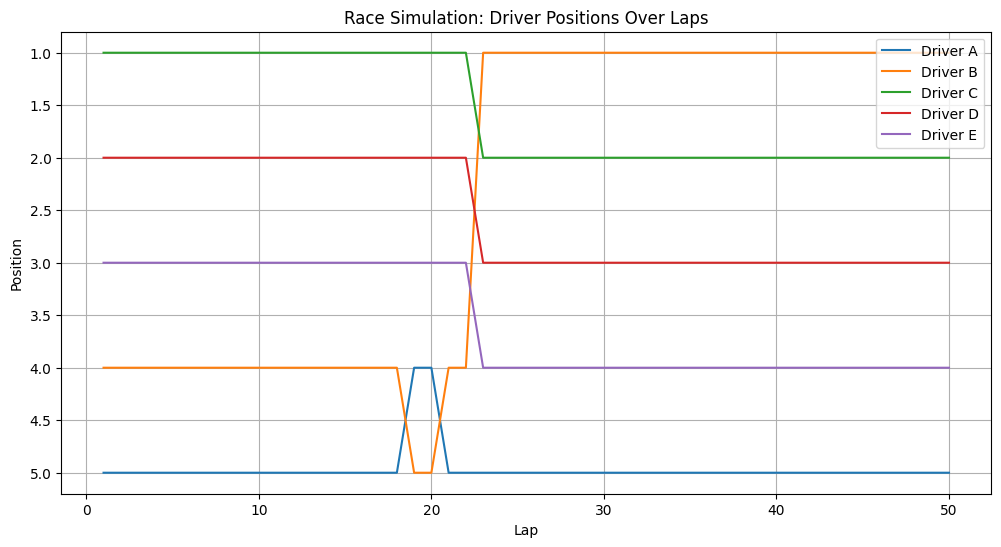

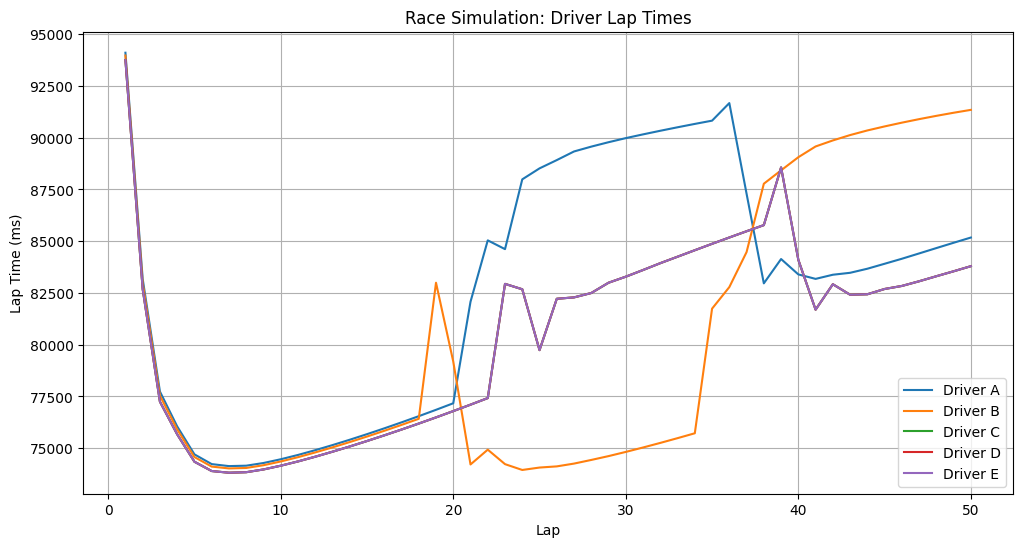

In [37]:
# Create an instance of the Race
race = Race(
    race_id=1,
    circuit_id=1,
    total_laps=50,
    weather_conditions={
        # You can define weather changes per lap if desired
        # For simplicity, we keep it constant
    }
)

compound_mapping = {
        'UNKNOWN': 0,
        'HARD': 1,
        'MEDIUM': 2,
        'SOFT': 3,
        'INTERMEDIATE': 4,
        'WET': 5
    }


# Define drivers with varying skills, attributes, and pit strategies
drivers_data = [
    {
        'driver_id': 1,
        'name': 'Driver A',
        'static_features': [
            0.85,    # driver_overall_skill
            0.80,    # driver_circuit_skill
            0.75,    # driver_consistency
            0.90,    # driver_reliability
            0.60,    # driver_aggression
            0.55,    # driver_risk_taking
            88000,   # fp1_median_time
            87500,   # fp2_median_time
            87000,   # fp3_median_time
            86000,   # quali_time
            310,     # constructor_performance
            1        # circuitId
        ],
        'initial_dynamic_features': {
            'tire_age': 0,
            'fuel_load': 100.0,  # Starting fuel load
            'track_position': 1,
            'track_temp': 35.0,
            'air_temp': 25.0,
            'humidity': 50.0,
            'TrackStatus': 1,
            'is_pit_lap': 0
        },
        'start_position': 1,
        'pit_strategy': [(20, 3), (35, 2)],  # Pit on lap 20 to Soft, lap 35 to Medium
        'starting_compound': 1  # Starting on Hard compound
    },
    # Define other drivers similarly, with their own pit strategies
    {
        'driver_id': 2,
        'name': 'Driver B',
        'static_features': [
            0.80,
            0.78,
            0.72,
            0.88,
            0.65,
            0.60,
            88200,
            87700,
            87200,
            86200,
            300,
            1
        ],
        'initial_dynamic_features': {
            'tire_age': 0,
            'fuel_load': 100.0,
            'track_position': 2,
            'track_temp': 35.0,
            'air_temp': 25.0,
            'humidity': 50.0,
            'TrackStatus': 1,
            'is_pit_lap': 0
        },
        'start_position': 2,
        'pit_strategy': [(18, 1), (34, 3)],
        'starting_compound': 1  # Starting on Hard compound
    },
    # Add more drivers with their own pit strategies
    {
        'driver_id': 3,
        'name': 'Driver C',
        'static_features': [
            0.78,
            0.75,
            0.70,
            0.85,
            0.70,
            0.65,
            88500,
            88000,
            87500,
            86500,
            280,
            1
        ],
        'initial_dynamic_features': {
            'tire_age': 0,
            'fuel_load': 100.0,
            'track_position': 3,
            'track_temp': 35.0,
            'air_temp': 25.0,
            'humidity': 50.0,
            'TrackStatus': 1,
            'is_pit_lap': 0
        },
        'start_position': 3,
        'pit_strategy': [(22, 2), (38, 2)],
        'starting_compound': 1  # Starting on Hard compound
    },
    # Add more drivers with their own pit strategies
    {
        'driver_id': 4,
        'name': 'Driver D',
        'static_features': [
            0.78,
            0.75,
            0.70,
            0.85,
            0.70,
            0.65,
            88500,
            88000,
            87500,
            86500,
            280,
            1
        ],
        'initial_dynamic_features': {
            'tire_age': 0,
            'fuel_load': 100.0,
            'track_position': 3,
            'track_temp': 35.0,
            'air_temp': 25.0,
            'humidity': 50.0,
            'TrackStatus': 1,
            'is_pit_lap': 0
        },
        'start_position': 3,
        'pit_strategy': [(22, 2), (38, 2)],
        'starting_compound': 1  # Starting on Hard compound
    },
    # Add more drivers with their own pit strategies
    {
        'driver_id': 5,
        'name': 'Driver E',
        'static_features': [
            0.78,
            0.75,
            0.70,
            0.85,
            0.70,
            0.65,
            88500,
            88000,
            87500,
            86500,
            280,
            1
        ],
        'initial_dynamic_features': {
            'tire_age': 0,
            'fuel_load': 100.0,
            'track_position': 3,
            'track_temp': 35.0,
            'air_temp': 25.0,
            'humidity': 50.0,
            'TrackStatus': 1,
            'is_pit_lap': 0
        },
        'start_position': 3,
        'pit_strategy': [(22, 2), (38, 2)],
        'starting_compound': 1  # Starting on Hard compound
    }
    
]

# Create the simulator
model, preprocessor = load_model_with_preprocessor('f1_prediction_model.pth')
simulator = RaceSimulator(model, preprocessor)

# Add drivers to the race
for d in drivers_data:
    driver = Driver(
        driver_id=d['driver_id'],
        name=d['name'],
        static_features=d['static_features'],
        initial_dynamic_features=d['initial_dynamic_features'],
        start_position=d['start_position'],
        pit_strategy=d['pit_strategy'],
        starting_compound=d['starting_compound']
    )

    # Set starting compound
    driver.dynamic_features['tire_compound'] = driver.starting_compound

    # Scale static features
    static_features_scaled = preprocessor.static_scaler.transform([driver.static_features]).flatten()
    driver.static_features = static_features_scaled

    # Define the features to scale
    dynamic_features_to_scale = [
        col for col in preprocessor.race_features.dynamic_features
        if col not in ['tire_compound']
    ]

    # Extract 'tire_compound' separately
    tire_compound_value = driver.dynamic_features['tire_compound']

    # Extract and scale other dynamic features
    other_dynamic_feature_values = np.array([
        driver.dynamic_features[feature] for feature in dynamic_features_to_scale
    ])
    other_dynamic_features_scaled = preprocessor.dynamic_scaler.transform(
        other_dynamic_feature_values.reshape(1, -1)
    ).flatten()

    # Combine 'tire_compound' (not scaled) with the scaled dynamic features
    dynamic_features_combined = np.hstack((tire_compound_value, other_dynamic_features_scaled))

    # Initialize the driver's sequence
    lap_times = [90000, 89500, 89200]  # Example initial lap times
    lap_times_scaled = preprocessor.lap_time_scaler.transform(
        np.array(lap_times).reshape(-1, 1)
    ).flatten()
    sequence = np.hstack((
        lap_times_scaled.reshape(-1, 1),
        np.tile(dynamic_features_combined, (3, 1))
    ))
    driver.sequence = sequence
    driver.dynamic_features_scaled = dynamic_features_combined

    # Add driver to the race
    race.drivers.append(driver)

# Simulate the race
race_lap_data = simulator.simulate_race(race)

# Generate DataFrame with lap times and inputs
lap_times_inputs_df = create_lap_times_with_inputs_dataframe(race, preprocessor.race_features)

# Display the DataFrame to verify its structure
print(lap_times_inputs_df.head())

# Optionally, save to CSV
lap_times_inputs_df.to_csv('race_lap_times_with_inputs.csv', index=False)



# Plot race positions and lap times (optional)
plot_race_positions(race)
plot_lap_times(race)


